In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
                                                   shuffle= True,
                                                   image_size =(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size = BATCH_SIZE)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


(256, 256, 3)


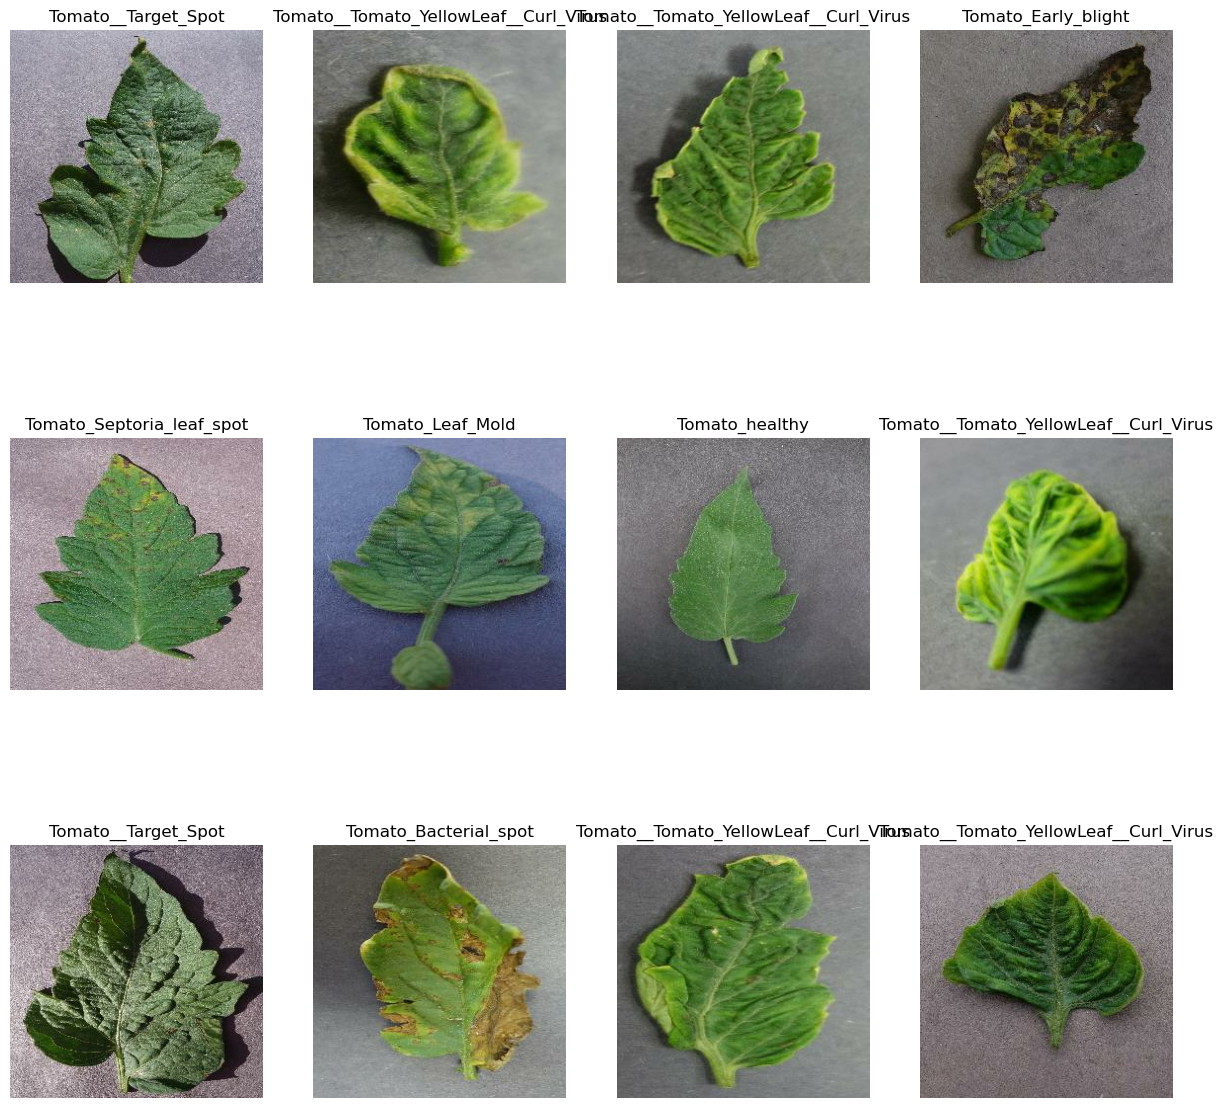

In [5]:
plt.figure(figsize =(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    print(image_batch[0].shape)

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.1, val_split= 0.1, test_split=0.1, shuffle =True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = dataset.take(train_size)
    
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
#cache() It will read image from the disk and then you will need same image for next iteration so it will keep image in the memory
# cache() so you need to read same image for every iteration (it help performance)
train_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
# Our images are already 256 by 256 why do we need to resize it?
# This resize_and_rescale will eventually go to our ultimate model when it starts to predicting
# during prediction if youre supplying any image which is not 256 by 256 this layer will take care of that dimension 
resize_and_rescale = tf.keras.Sequential([
    # this will resize the images
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # dont worry experimental it is stable 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmention = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                    layers.experimental.preprocessing.RandomRotation(0.2)])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmention,
    layers.Conv2D(32, (3,3), activation= "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(n_classes, activation= "softmax"),
])
model.build(input_shape = input_shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [13]:
model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                   metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,
         epochs = EPOCH,
         batch_size = BATCH_SIZE,
         verbose = 1,
         validation_data = val_ds           
                   )

Epoch 1/50
50/50 [==============================] - 45s 874ms/step - loss: 2.1527 - accuracy: 0.2113 - val_loss: 1.9967 - val_accuracy: 0.3338
Epoch 2/50
50/50 [==============================] - 42s 837ms/step - loss: 1.8589 - accuracy: 0.3419 - val_loss: 1.6815 - val_accuracy: 0.3931
Epoch 3/50
50/50 [==============================] - 40s 812ms/step - loss: 1.7365 - accuracy: 0.3781 - val_loss: 1.5252 - val_accuracy: 0.4694
Epoch 4/50
50/50 [==============================] - 40s 797ms/step - loss: 1.5513 - accuracy: 0.4306 - val_loss: 1.6691 - val_accuracy: 0.4281
Epoch 5/50
50/50 [==============================] - 40s 809ms/step - loss: 1.3794 - accuracy: 0.4975 - val_loss: 1.3355 - val_accuracy: 0.5213
Epoch 6/50
50/50 [==============================] - 39s 792ms/step - loss: 1.2308 - accuracy: 0.5650 - val_loss: 1.1626 - val_accuracy: 0.5894
Epoch 7/50
50/50 [==============================] - 40s 807ms/step - loss: 1.1497 - accuracy: 0.5931 - val_loss: 1.5434 - val_accuracy: 0.4888

In [15]:
scores = model.evaluate(test_ds)

401/401 [==============================] - 63s 141ms/step - loss: 1.0699 - accuracy: 0.7392


In [16]:
history.params 

{'verbose': 1, 'epochs': 50, 'steps': 50}

In [17]:
acc= history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

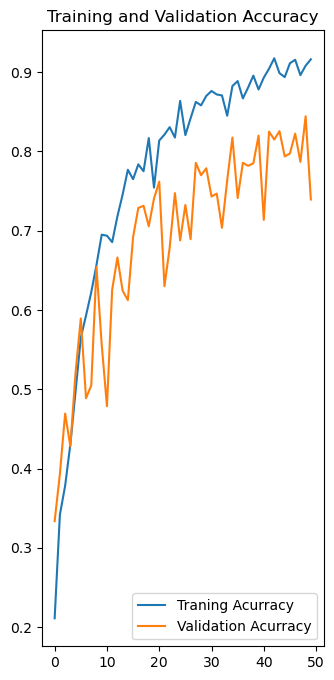

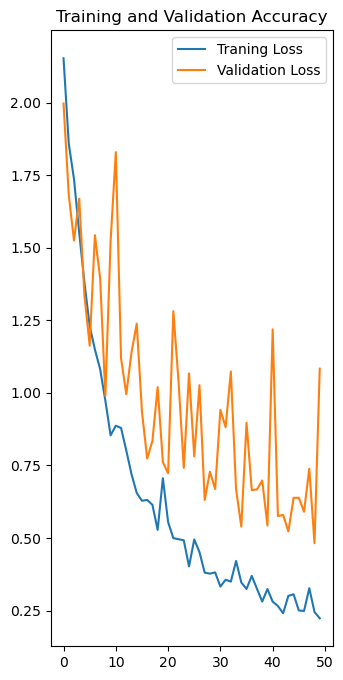

In [18]:
plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label ='Traning Acurracy')
plt.plot(range(EPOCH), val_acc, label ='Validation Acurracy')
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# plt.axis("off")

plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), loss, label ='Traning Loss')
plt.plot(range(EPOCH), val_loss, label ='Validation Loss')
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")

First image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 1s 739ms/step
Predicted Label:  Tomato_Late_blight


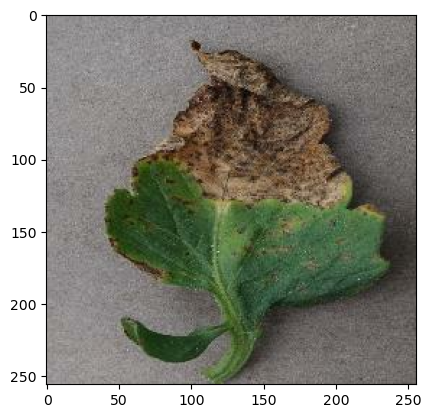

In [19]:
# Lets make prediction
for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy().astype('uint8'))
    #plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image =images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    # prediction for 32 images in the batch
    batch_prediction = model.predict(images_batch)
    # There is three probability here because we have three class in the softmax
    # whichever has the highest probability that is the class 
    #print(batch_prediction[0])
    # np.argmax will return the index of max item
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])
    

### Write a function for inference

In [20]:
def predict(model, img):
    # convert image to image array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 21ms/step


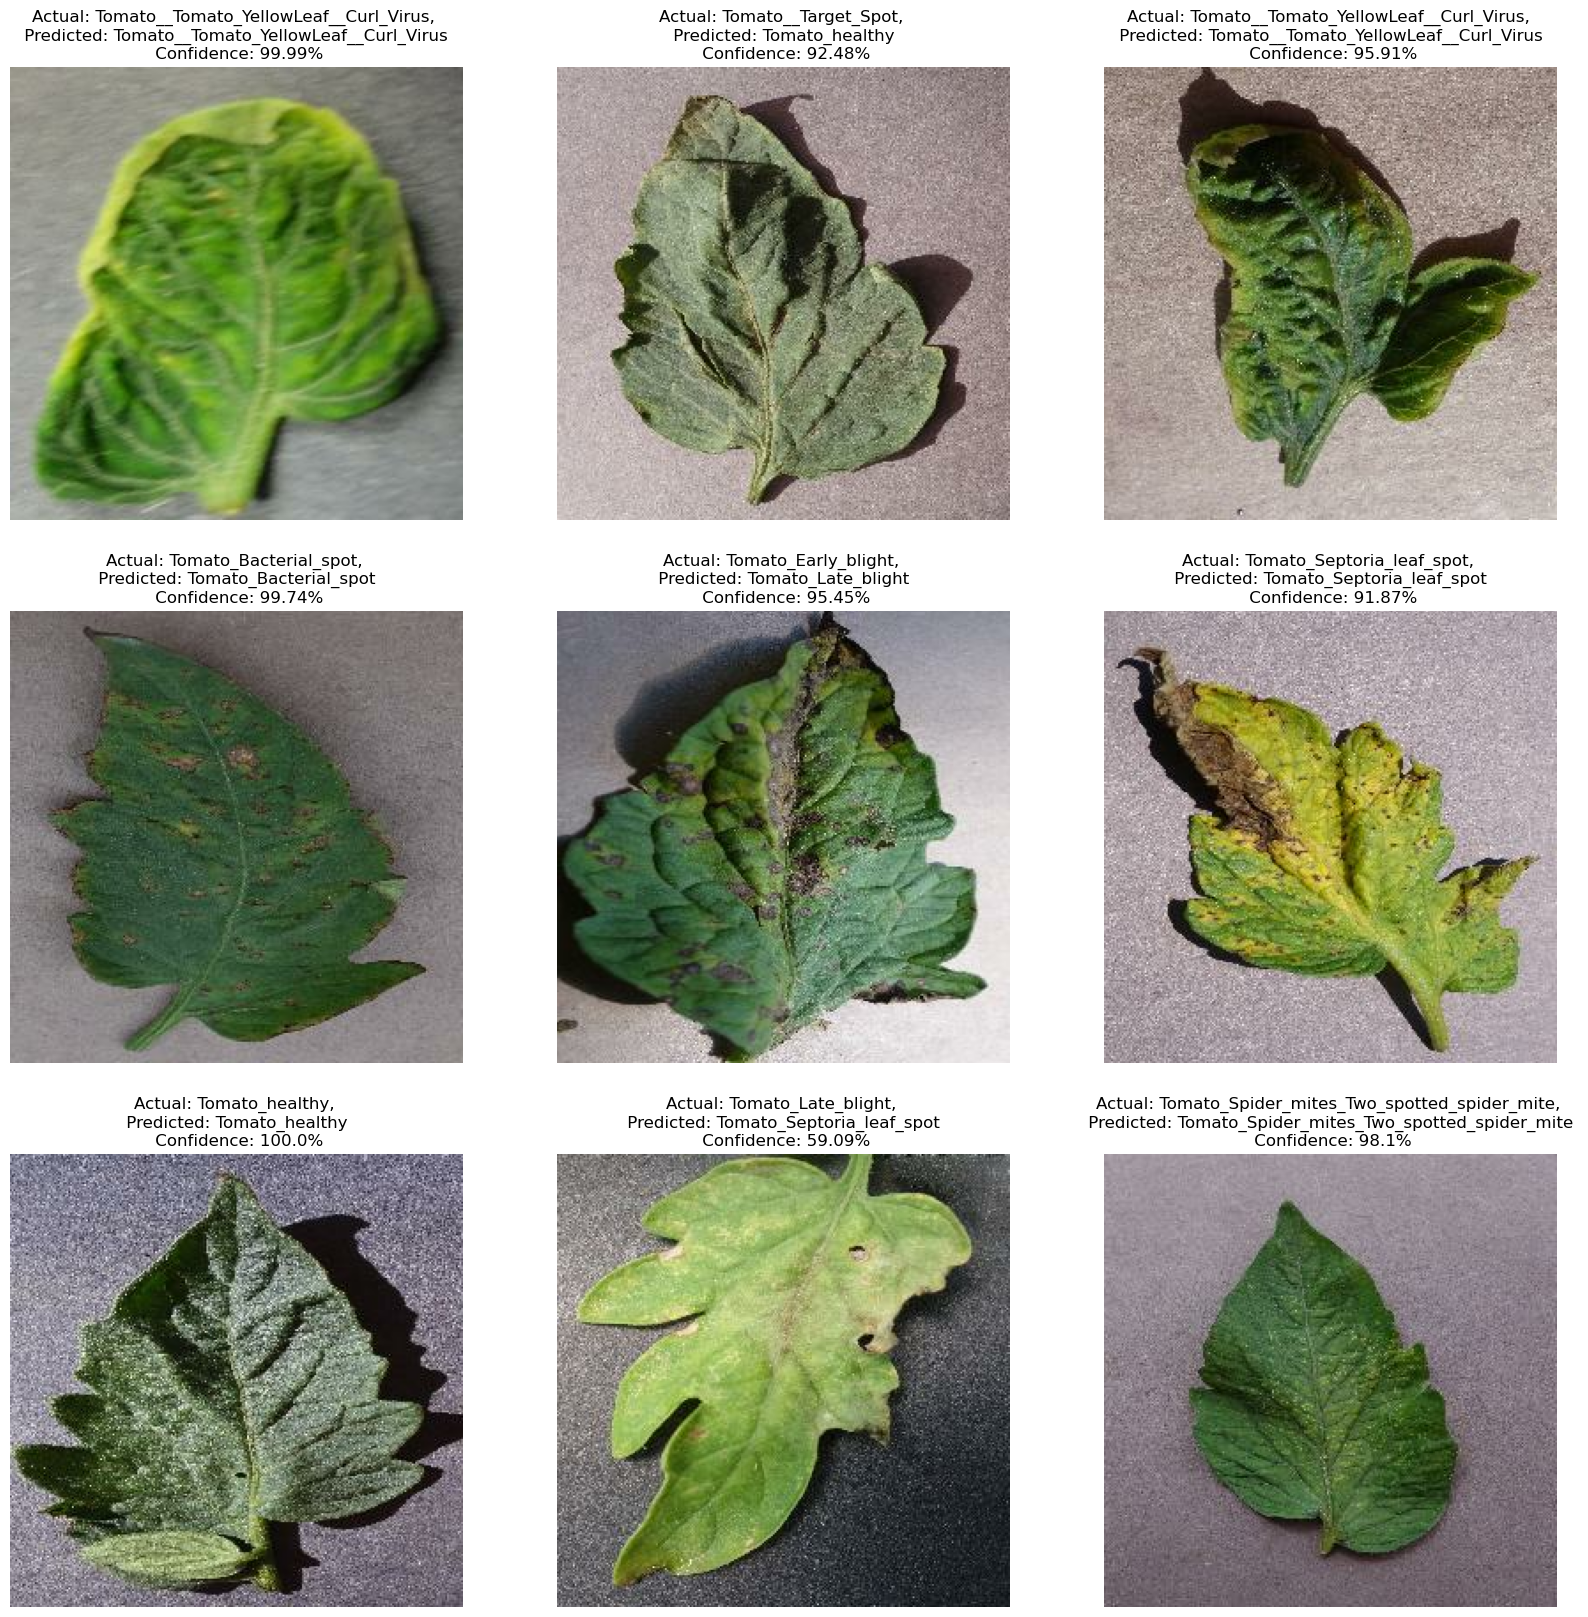

In [21]:
plt.figure(figsize =(20,20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")

### Saving the Model
* We append the model to the list of models as a new version

In [23]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [24]:

model.save("../potatoes.h5")